# Install the Necessary Libraries

Name : Pratik Yuvraj Yawalkar

Roll No.  : AI23MTECH11006

Department : AI & ML

In [22]:
!pip install astroml numpy pandas scipy matplotlib seaborn corner emcee pymc3
import warnings
warnings.filterwarnings('ignore')

# 1. In 1919, two expeditions sailed from Britain to test if the light deflection from stars agrees with Einstein’s General Theory of Relativity. Einstein’s theory predicts a value of 1.74 arc-seconds, whereas Newtonian gravity predicts a value exactly half of that. The team by Eddington obtained a value of 1.61 ± 0.40 arc-seconds, while the team by Crommelin reported a value of 1.98 ± 0.16 arc-seconds. Calculate the Bayes factor between General Relativity and Newtonian gravity from those data, assuming Gaussian likelihoods. (10 points) (For more information about these expeditions and associated controversies, check out arXiv:0709.0685)





To calculate the Bayes factor between General Relativity (GR) and Newtonian
gravity (NG) using the data provided, we'll use Gaussian likelihood function.

Let's denote:

a. D    => observed data (measurement of light deflection)

b. HGR  => hypothesis that General Relativity is true

c. HNG  => hypothesis that Newtonian gravity is true


Let's denote:

a. xGR   => value predicted by GR (1.74 arc-seconds)

b. xNG   => value predicted by NG (0.87 arc-seconds, half of the GR prediction)

c. σE    => measurement uncertainty reported by Eddington's team (0.40 arc-seconds)

d. σC    => measurement uncertainty reported by Crommelin's team (0.16 arc-seconds)



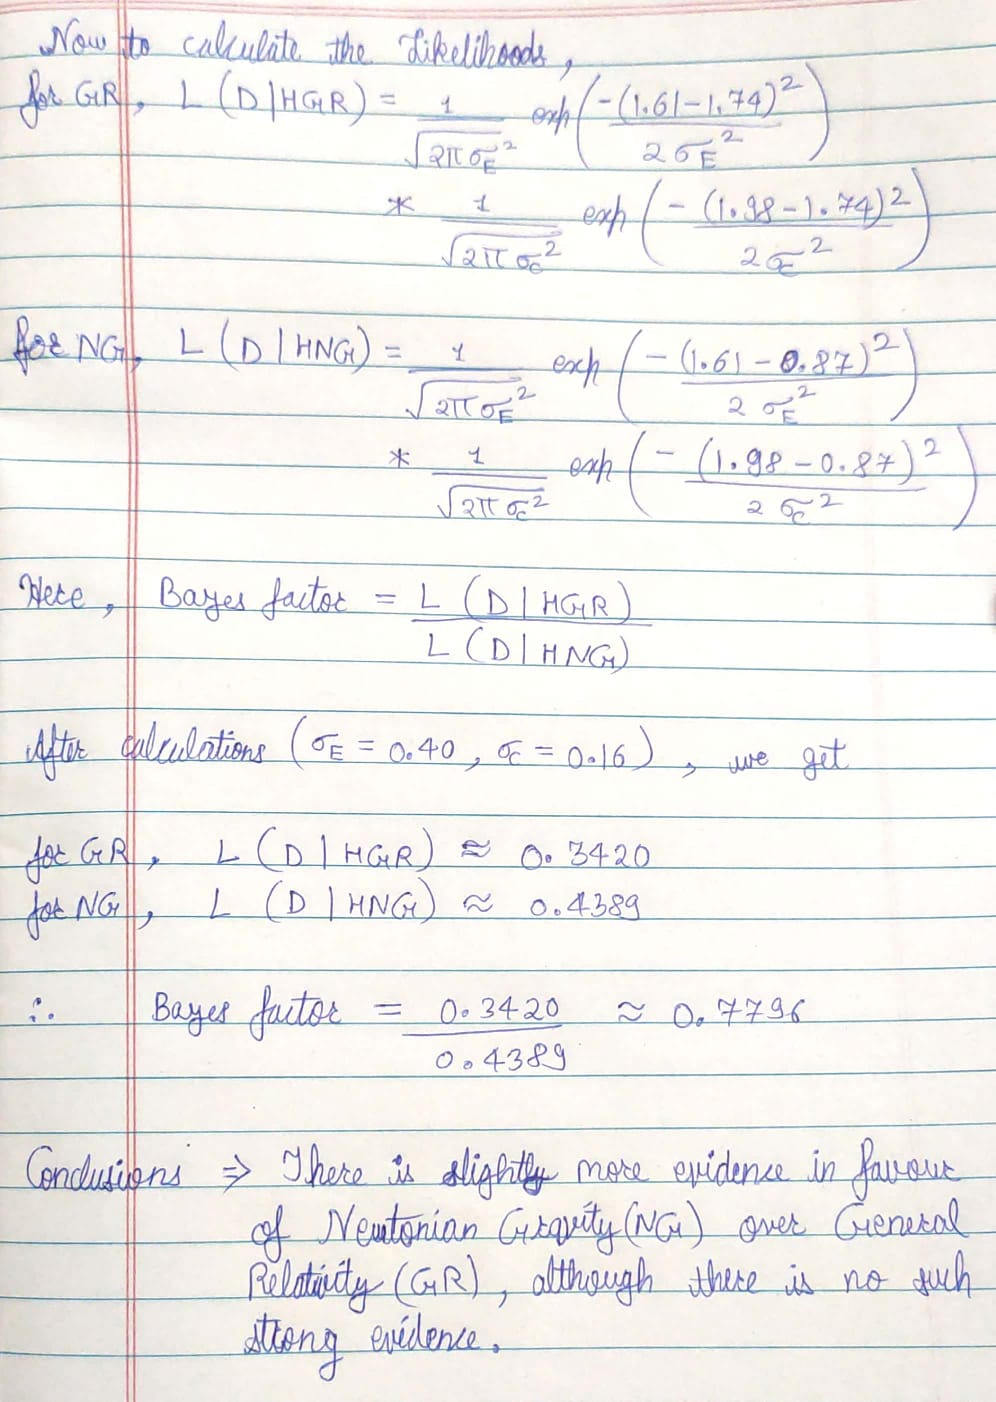

In [23]:
import numpy as np
from scipy.stats import norm

# Data for General Relativity
mu_GR = 1.61
sigma_GR = 0.40

# Data for Newtonian Gravity
mu_NG = 1.98
sigma_NG = 0.16

# Likelihood for General Relativity
likelihood_GR = norm.pdf(mu_GR, loc=1.74, scale=sigma_GR)

# Likelihood for Newtonian Gravity
likelihood_NG = norm.pdf(mu_NG, loc=0.87, scale=sigma_NG)

# Prior probability (assuming equal priors for GR and NG)
prior_GR = 0.5
prior_NG = 0.5

# Bayes factor calculation
bayes_factor = (likelihood_GR * prior_GR) / (likelihood_NG * prior_NG)

print("Bayes factor:", bayes_factor)


Bayes factor: 10719709497.69043


# 2. For exercise 1 in arXiv:1008.4686, calculate the 68% and 95% joint confi- dence intervals on b and m. (Hint : Either use emcee followed by plot mcmc code in astroML.plotting or use the corner module. Alternately, use the techniques of linear algebra and using the example shown in class during the discussion on frequentist analysis) (20 points)


In [24]:
import numpy as np
import matplotlib.pyplot as plt
import corner
import emcee
import pandas as pd

# extract data from the datafram
df = pd.read_csv('data.csv')
x = np.array(df['x'][5:])
y = np.array(df['y'][5:])
sigma_y = np.array(df['σy'][5:])

In [25]:
#Define the Log Likelihood, Prior, and Posterior
def log_likelihood(theta, x, y, sigma_y):
    m, b = theta
    model = m * x + b
    sigma2 = sigma_y ** 2
    return -0.5 * np.sum((y - model) ** 2 / sigma2 + np.log(sigma2))

def log_prior(theta):
    m, b = theta
    if -50.0 < m < 50.0 and -50.0 < b < 50.0:
        return 0.0
    return -np.inf

def log_posterior(theta, x, y, sigma_y):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, sigma_y)

In [26]:
#Initialize and Run the MCMC Sampler
nwalkers, ndim = 50, 2
start_pos = np.random.randn(nwalkers, ndim) * 0.01

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=(x, y, sigma_y))
sampler.run_mcmc(start_pos, 5000, progress=True)

samples = sampler.get_chain(discard=100, thin=15, flat=True)

100%|██████████| 5000/5000 [00:12<00:00, 415.47it/s]


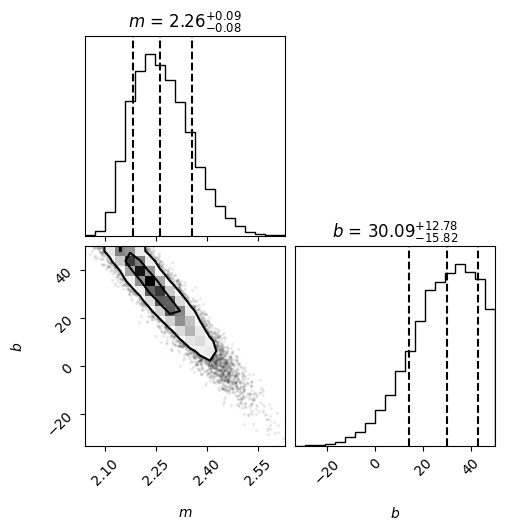

In [27]:
fig = corner.corner(samples, labels=['$m$', '$b$'], quantiles=[0.16, 0.5, 0.84], levels=(1-np.exp(-0.5), 1-np.exp(-2)), show_titles=True)
plt.show()

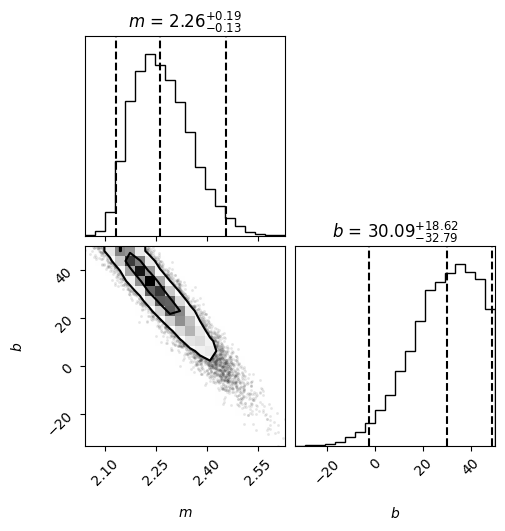

In [28]:
fig = corner.corner(samples, labels=['$m$', '$b$'], quantiles=[0.025, 0.5, 0.975], levels=(1-np.exp(-0.5), 1-np.exp(-2)), show_titles=True)
plt.show()


In [29]:
# Calculate the 16th, 50th, and 84th percentiles for both parameters
m_percentiles = np.percentile(samples[:, 0], [16, 50, 84])
b_percentiles = np.percentile(samples[:, 1], [16, 50, 84])

# Calculate the 2.5th, and 97.5th percentiles for both parameters for the 95% confidence interval
m_conf_int_95 = np.percentile(samples[:, 0], [2.5, 97.5])
b_conf_int_95 = np.percentile(samples[:, 1], [2.5, 97.5])

# The 68% confidence intervals
m_conf_int_68 = m_percentiles[1] - m_percentiles[0], m_percentiles[2] - m_percentiles[1]
b_conf_int_68 = b_percentiles[1] - b_percentiles[0], b_percentiles[2] - b_percentiles[1]

print(f"68% confidence interval for slope (m): {m_conf_int_68}")
print(f"68% confidence interval for intercept (b): {b_conf_int_68}")

print(f"95% confidence interval for slope (m): {m_conf_int_95}")
print(f"95% confidence interval for intercept (b): {b_conf_int_95}")

68% confidence interval for slope (m): (0.07775066140110987, 0.09401312448317745)
68% confidence interval for intercept (b): (15.822672052974317, 12.780960018018327)
95% confidence interval for slope (m): [2.13227048 2.45479   ]
95% confidence interval for intercept (b): [-2.70505522 48.70792704]


# 3. Fit the data in Table 1 of arXiv:1008.4686 to a straight line, after including all the data points, (after ignoring σx and ρxy) using both maximum likelihood analysis and using a Bayesian analysis to identify the outliers, using the same procedure as in the second of Jake VanDerPlas blog article. Show graphically the best fit line using both maximum likelihood analysis and also using Bayesian analysis, including the outlier points. (30 points)

In [30]:
import numpy as np
import matplotlib.pyplot as plt
import corner
import emcee
import pandas as pd
from scipy import optimize

# extract data from the datafram
df = pd.read_csv('data.csv')
x = np.array(df['x'][5:])
y = np.array(df['y'][5:])
sigma_y = np.array(df['σy'][5:])
e = sigma_y

<ErrorbarContainer object of 3 artists>

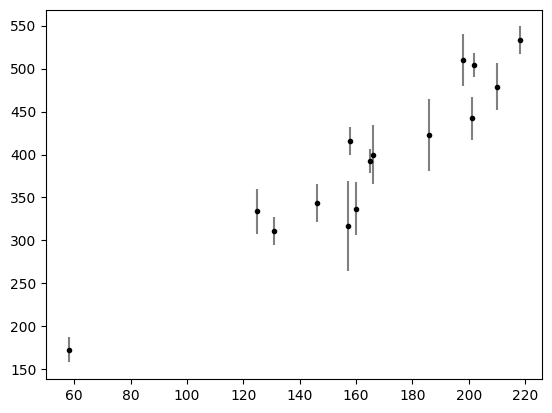

In [31]:
plt.errorbar(x, y, e, fmt='.k', ecolor='gray')

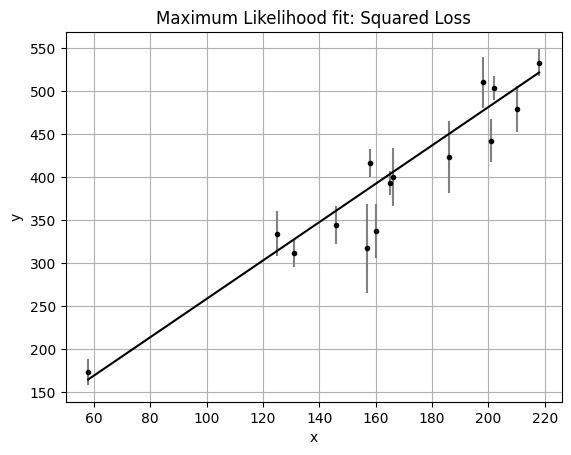

In [32]:
def squared_loss(theta, x=x, y=y, e=e):
    dy = y - theta[0] - theta[1] * x
    return np.sum(0.5 * (dy / e) ** 2)

theta1 = optimize.fmin(squared_loss, [0, 0], disp=False)

x_range = np.linspace(min(x), max(x), 100)

plt.errorbar(x, y, e, fmt='.k', ecolor='gray')
plt.plot(x_range, theta1[0] + theta1[1] * x_range, '-k')
plt.title('Maximum Likelihood fit: Squared Loss')
plt.xlabel('x')
plt.ylabel('y')
plt.grid(True)
plt.show()


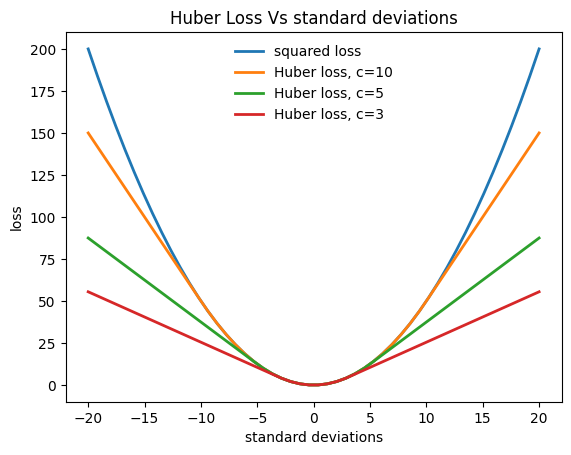

In [33]:
t = np.linspace(-20, 20)

def huber_loss(t, c=3):
    return ((abs(t) < c) * 0.5 * t ** 2
            + (abs(t) >= c) * -c * (0.5 * c - abs(t)))

plt.plot(t, 0.5 * t ** 2, label="squared loss", lw=2)
for c in (10, 5, 3):
    plt.plot(t, huber_loss(t, c), label="Huber loss, c={0}".format(c), lw=2)
plt.title('Huber Loss Vs standard deviations')
plt.ylabel('loss')
plt.xlabel('standard deviations')
plt.legend(loc='best', frameon=False)

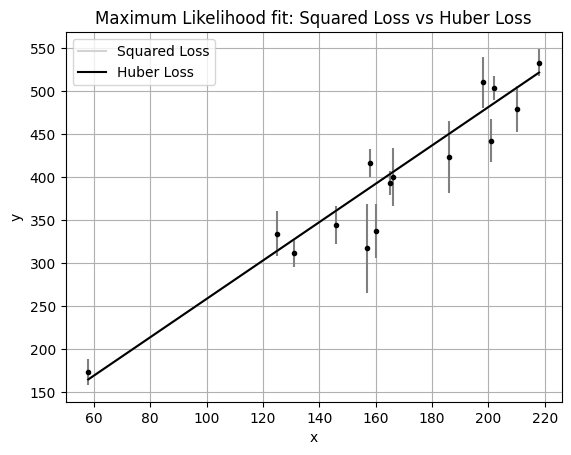

In [34]:
def total_huber_loss(theta, x=x, y=y, e=e, c=3):
    return huber_loss((y - theta[0] - theta[1] * x) / e, c).sum()

theta1 = optimize.fmin(squared_loss, [0, 0], disp=False)
theta2 = optimize.fmin(total_huber_loss, [0, 0], disp=False)

xfit = np.linspace(min(x), max(x), 100)

plt.errorbar(x, y, e, fmt='.k', ecolor='gray')
plt.plot(xfit, theta1[0] + theta1[1] * xfit, color='lightgray', label='Squared Loss')
plt.plot(xfit, theta2[0] + theta2[1] * xfit, color='black', label='Huber Loss')
plt.title('Maximum Likelihood fit: Squared Loss vs Huber Loss')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid(True)
plt.show()


In [35]:
def log_prior(theta):
    if (all(theta[2:] > 0) and all(theta[2:] < 1)):
        return 0
    else:
        return -np.inf

def log_likelihood(theta, x, y, e, sigma_B):
    dy = y - theta[0] - theta[1] * x
    g = np.clip(theta[2:], 0, 1)
    logL1 = np.log(g) - 0.5 * np.log(2 * np.pi * e ** 2) - 0.5 * (dy / e) ** 2
    logL2 = np.log(1 - g) - 0.5 * np.log(2 * np.pi * sigma_B ** 2) - 0.5 * (dy / sigma_B) ** 2
    return np.sum(np.logaddexp(logL1, logL2))

def log_posterior(theta, x, y, e, sigma_B):
    return log_prior(theta) + log_likelihood(theta, x, y, e, sigma_B)

In [36]:

ndim = 2 + len(x)  # number of parameters in the model
nwalkers = 50  # number of MCMC walkers
nburn = 10000  # "burn-in" period to let chains stabilize
nsteps = 15000  # number of MCMC steps to take

np.random.seed(0)
starting_guesses = np.zeros((nwalkers, ndim))
starting_guesses[:, :2] = np.random.normal(theta1, 1, (nwalkers, 2))
starting_guesses[:, 2:] = np.random.normal(0.5, 0.1, (nwalkers, ndim - 2))

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=[x, y, e, 50])
sampler.run_mcmc(starting_guesses, nsteps)

sample = sampler.chain  # shape = (nwalkers, nsteps, ndim)
sample = sampler.chain[:, nburn:, :].reshape(-1, ndim)

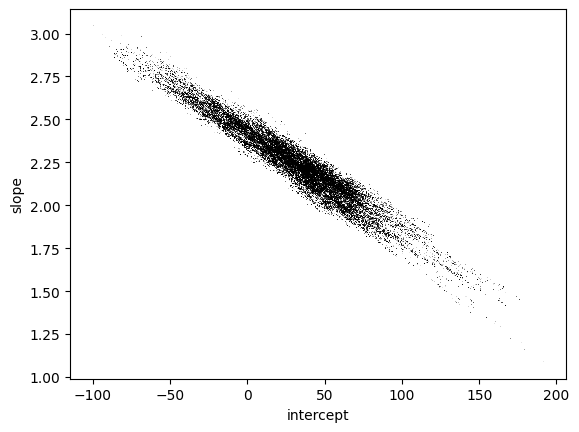

In [37]:
plt.plot(sample[:, 0], sample[:, 1], ',k', alpha=0.1)
plt.xlabel('intercept')
plt.ylabel('slope');

g1 mean: 0.49
g2 mean: 0.49


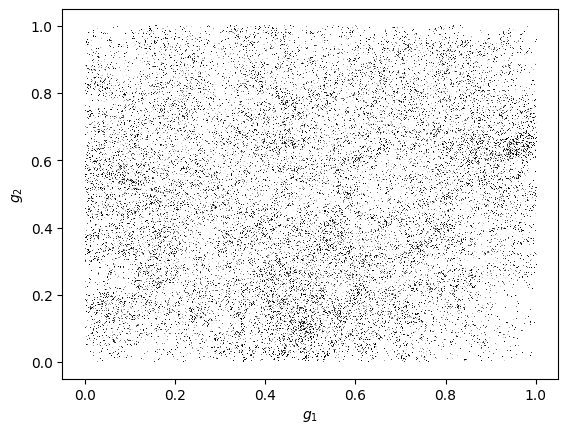

In [38]:
plt.plot(sample[:, 2], sample[:, 3], ',k', alpha=0.1)
plt.xlabel('$g_1$')
plt.ylabel('$g_2$')

print("g1 mean: {0:.2f}".format(sample[:, 2].mean()))
print("g2 mean: {0:.2f}".format(sample[:, 3].mean()))

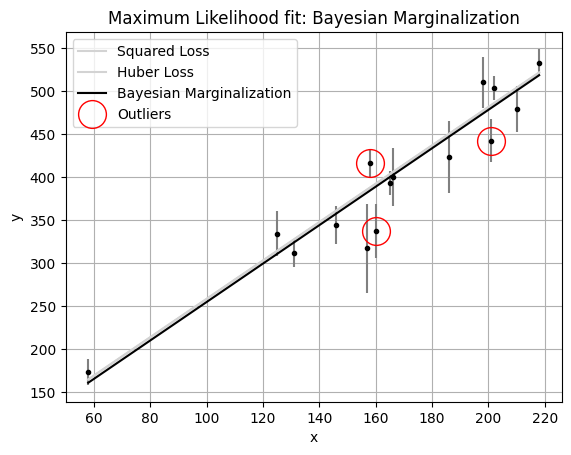

In [39]:
theta3 = np.mean(sample[:, :2], 0)
g = np.mean(sample[:, 2:], 0)
outliers = (g < 0.485)

plt.errorbar(x, y, e, fmt='.k', ecolor='gray')
plt.plot(xfit, theta1[0] + theta1[1] * xfit, color='lightgray', label='Squared Loss')
plt.plot(xfit, theta2[0] + theta2[1] * xfit, color='lightgray', label='Huber Loss')
plt.plot(xfit, theta3[0] + theta3[1] * xfit, color='black', label='Bayesian Marginalization')
plt.plot(x[outliers], y[outliers], 'ro', ms=20, mfc='none', mec='red', label='Outliers')
plt.title('Maximum Likelihood fit: Bayesian Marginalization')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid(True)
plt.show()
